# Getting Started with PowerSAM

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

import sys
sys.path.append("../")
from box_prompt_generator.apis import init_detector, inference_detector

In [2]:

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax, label=None, score=None):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

    if label is not None and score is not None:
        label_text = f"{label}: {score:.2f}"
        ax.text(x0, y0 - 2, label_text, fontsize=8, color="green")


## Example image

In [3]:
image_path = './images/1.jpg'
# image_path = './images/2.jpg'
# image_path = './images/3.jpg'
# image_path = './images/4.jpg'
# image_path = './images/5.jpg'


image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

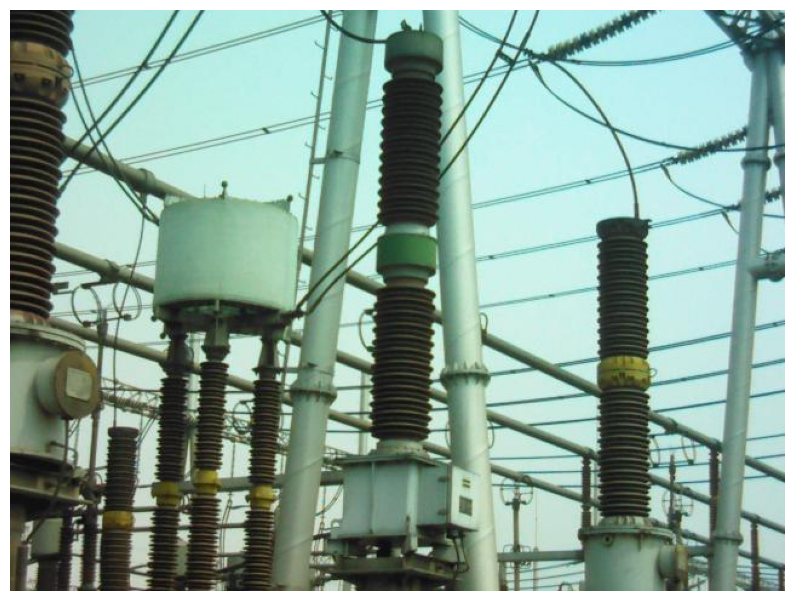

In [4]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)
ax.axis(False)
plt.show()

## Selecting objects with Bounding Box Prompt Generator and PowerSAM

First, load the Bounding Box Prompt Generator to produce box prompt.

In [5]:
bbpg_config = '../box_prompt_generator/configs/box_prompt_generator/self_s_repvit_m0.py'
bbpg_checkpoint = '../weights/box_prompt_generator_repvit_epoch_300.pth'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
bbox_detector = init_detector(bbpg_config, bbpg_checkpoint, device=device)
label2class = ('TA', 'W', 'SQR', 'L', 'FV', 'CM', 'TV', 'QF', 'C', 'T', 'JYZ', 'QS')

Loads checkpoint by local backend from path: ../weights/box_prompt_generator_repvit_epoch_300.pth


Second, load the PowerSAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [6]:
import sys
sys.path.append("..")
from power_sam import sam_model_registry, SamPredictor

model_type = "power_sam"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

sam_checkpoint = "../weights/powersam_s.pth"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint, arch="m0")

# sam_checkpoint = "../weights/powersam_b.pth"
# sam = sam_model_registry[model_type](checkpoint=sam_checkpoint, arch="m1")

sam.to(device=device)

predictor = SamPredictor(sam)

<All keys matched successfully>


## Bounding Box Prompts Generator

Bounding Box Prompts Generator is a crucial step in the object detection and segmentation workflow. It involves generating bounding boxes around objects of interest in an image. These bounding boxes serve as prompts for further processing, such as mask prediction and segmentation.

In this workflow, the bounding boxes are then transformed and used as input for the SAM (Segment Anything Model) to predict masks for the objects. This process allows for precise and efficient segmentation of objects within the image.

The following steps outline the process:
1. Load the Bounding Box Prompts Generator model and use it to detect objects and generate bounding boxes.
2. Transform the bounding boxes to the input frame for the SAM model.
3. Use the SAM model to predict masks based on the bounding boxes.

This approach leverages the strengths of both Bounding Box Prompts Generator for object detection and SAM for segmentation, resulting in accurate and detailed object masks.

In [ ]:
result = inference_detector(bbox_detector, image_path)

pred_instances = result.pred_instances
input_boxes = pred_instances.bboxes
bbox_labels = pred_instances.labels
bbox_scores = pred_instances.scores

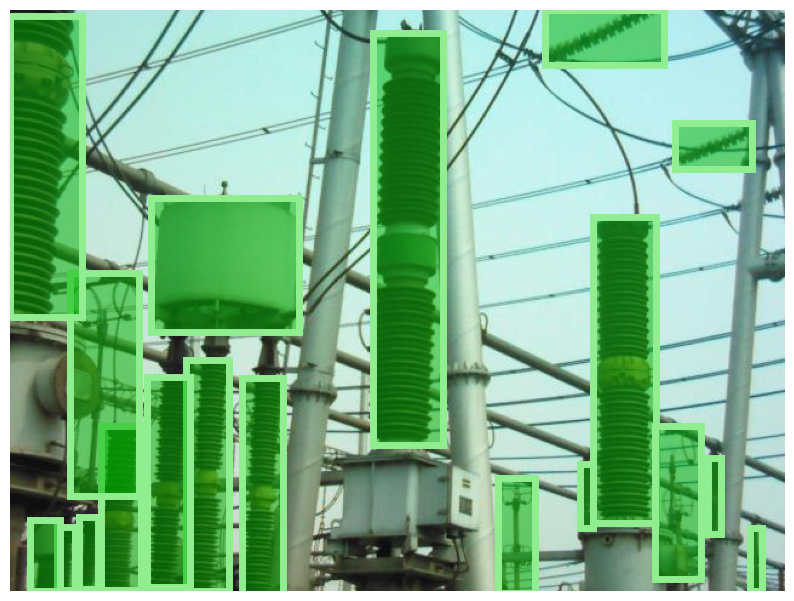

In [8]:
def show_box_for_smallvis(box, ax, label=None, score=None):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='lightgreen', facecolor=(0,0.7,0,0.5), lw=5))    

    if label is not None and score is not None:
        label_text = f"{label}: {score:.2f}"
        ax.text(x0, y0 - 2, label_text, fontsize=8, color="green")

plt.figure(figsize=(10, 10))
plt.imshow(image)
for box in input_boxes:
    show_box_for_smallvis(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

Then, transform the boxes to the input frame, then predict masks. `SamPredictor` stores the necessary transform as the `transform` field for easy access, though it can also be instantiated directly for use in e.g. a dataloader (see `segment_anything.utils.transforms`).

In [9]:
predictor.set_image(image)

transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    features=predictor.features,
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    num_multimask_outputs=1,
)

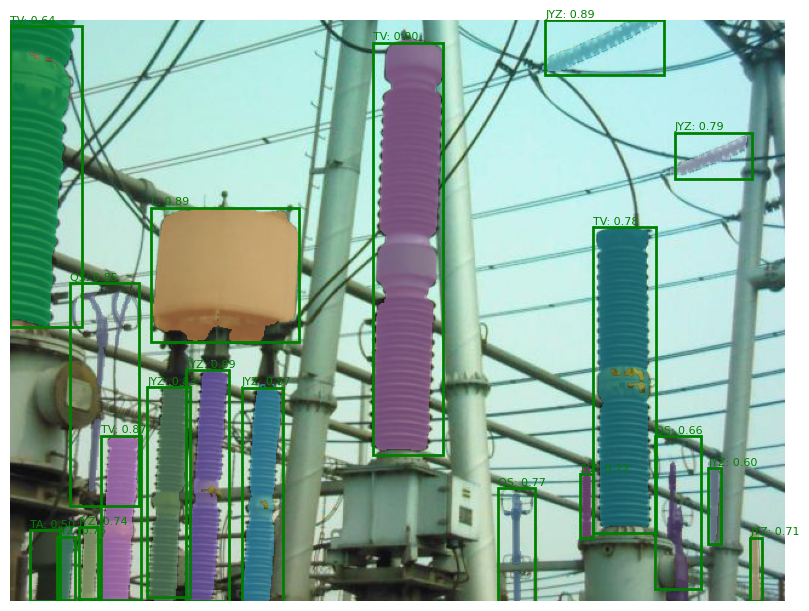

In [10]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
midx = 2
for mask in masks:
# for mask in masks[midx:midx+1]:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box, label, score in zip(input_boxes, bbox_labels, bbox_scores):
# for box in input_boxes[midx:midx+1]:
    show_box(box.cpu().numpy(), plt.gca(), label2class[label], score)
plt.axis('off')
plt.show()

## Decoupled Power System Predictor

The Decoupled Bounding Box Prompts Generator is a method used to generate bounding boxes around objects of interest in an image. This process is decoupled from the main segmentation model.

In [11]:
result = inference_detector(bbox_detector, image_path)

pred_instances = result.pred_instances

image_boxes = pred_instances.bboxes
image_labels = pred_instances.labels
image_scores = pred_instances.scores

Both images and prompts are input as PyTorch tensors that are already transformed to the correct frame. Inputs are packaged as a list over images, where each element is a dict that takes the following keys:
* `image`: The input image as a PyTorch tensor in CHW format.
* `boxes`: Batched input boxes.
* `original_size`: The size of the image before transforming for input to SAM, in (H, W) format.

In [12]:
from power_sam.utils.transforms import ResizeLongestSide
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

def prepare_image(image, transform, device):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device.device) 
    return image.permute(2, 0, 1).contiguous()

In [13]:
image1 = image  # truck.jpg from above
batched_input = [
     {
         'image': prepare_image(image1, resize_transform, sam),
         'boxes': resize_transform.apply_boxes_torch(image_boxes, image1.shape[:2]),
         'original_size': image1.shape[:2]
     },
]

Run the model.

In [14]:
batched_output = sam(batched_input, num_multimask_outputs=1)
batched_output[0].keys()

dict_keys(['masks', 'iou_predictions', 'low_res_logits'])

The output is a list over results for each input image, where list elements are dictionaries with the following keys:
* `masks`: A batched torch tensor of predicted binary masks, the size of the original image.
* `iou_predictions`: The model's prediction of the quality for each mask.
* `low_res_logits`: Low res logits for each mask, which can be passed back to the model as mask input on a later iteration.

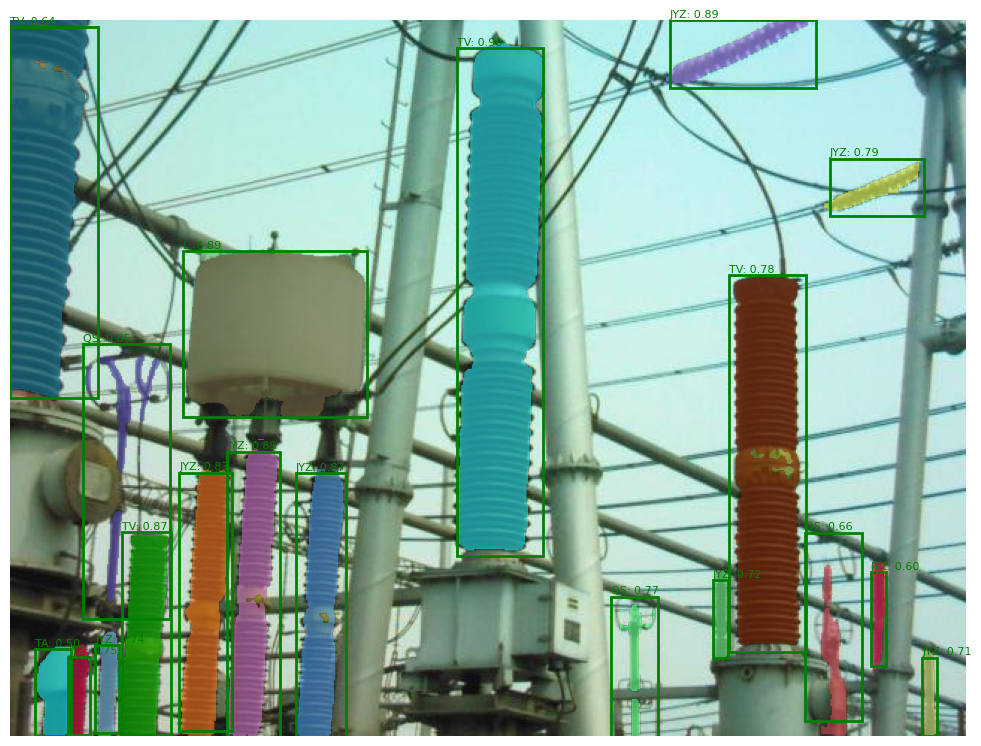

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.imshow(image1)
np.random.seed(2025)
for mask in batched_output[0]['masks']:
    show_mask(mask.cpu().numpy(), ax, random_color=True)
for box, label, score in zip(image_boxes, image_labels, image_scores):
    show_box(box.cpu().numpy(), ax, label2class[label], score)
ax.axis('off')

plt.tight_layout()
plt.show()

## Shared Knowledge Power System Predictor

The Shared Knowledge Power System Predictor is designed to leverage shared knowledge across multiple modules to improve the performance of segmentation and object detection. This model integrates the strengths of various components, including bounding box prompts, image embeddings, and mask prediction, to achieve accurate and efficient segmentation results.

### Workflow:
1. **Generate Image Features**: The image features are generated once and shared between the bounding box prompt generator and the SAM model.
2. **Load the Bounding Box Prompts Generator**: Initialize the bounding box detector and use it to detect objects in the image.
3. **Generate Bounding Boxes**: The detected objects are enclosed in bounding boxes, which are then transformed to the input frame for the SAM model.
4. **Predict Masks**: Using the bounding boxes and image embedding, the SAM model predicts masks for the objects.

In [16]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

result, feats = inference_detector(bbox_detector, image, return_feats=True)
pred_instances = result.pred_instances
image_boxes = pred_instances.bboxes
image_labels = pred_instances.labels
image_scores = pred_instances.scores

transformed_boxes = predictor.transform.apply_boxes_torch(image_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    feats[-1] if feats[-1].shape[-2:] == (64, 64)
    else torch.nn.functional.interpolate(feats[-1], (64, 64), mode="bilinear"),
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    num_multimask_outputs=1,
)

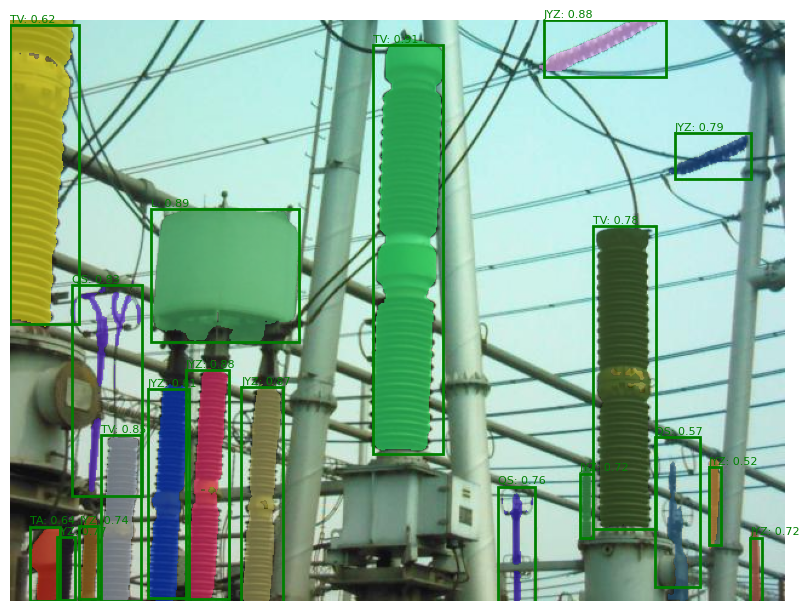

In [17]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box, label, score in zip(image_boxes, image_labels, image_scores):
    show_box(box.cpu().numpy(), plt.gca(), label2class[label], score)
plt.axis('off')
plt.show()